In [65]:
import json
import pandas as pd
import requests
import numpy as np
import random
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import neo4j
from neo4j import GraphDatabase
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
sns.set_style("whitegrid")

In [67]:
## APIS USED!
# 1. Random Users at randomuser.me/api
# 2. https://quote-garden.herokuapp.com/api
# 3. https://kanye.rest/
# 4. https://taylor.rest/
# 5. https://gameofthronesquotes.xyz/

In [68]:
filename = "random_users.json"
results_wanted = 1000

In [69]:
random_users_base_url = "https://randomuser.me/api?"
random_users_specifics = f"format=json&&nat=us&&noinfo&&inc=gender,name,nat,location,phone,email,dob&&results={results_wanted}"

In [70]:
random_users_final_url = random_users_base_url + random_users_specifics
response = requests.get(url=random_users_final_url)
random_users = json.loads(response.text)["results"]
with open(filename, "w+") as f:
    f.write(json.dumps(random_users, sort_keys=True,indent=4))

In [71]:
df = pd.read_json(filename)
# start new dfs of flattened files
df_dob = df["dob"].apply(pd.Series)
df_location = df["location"].apply(pd.Series)
df_location_good = df_location[["city", "country", "postcode", "state"]]
df_location_coordinates = df_location["coordinates"].apply(pd.Series)
df_location_street = df_location["street"].apply(pd.Series)
df_location_timezone = df_location["timezone"].apply(pd.Series)
df_name = df["name"].apply(pd.Series)

In [72]:
df_refreshed = df.drop(["dob", "name", "location"], axis=1)
df_new = pd.concat([df_refreshed, df_name, df_dob, df_location_good, df_location_street, 
                    df_location_coordinates, df_location_timezone], axis=1)

svc_reps = ["Tim", "Jen", "Dan", "Gina", "Mark", "Jolene", "Kurt", "Patty"]
bank_locs = ["East", "North", "South", "West"]
df_new["svc_rep"] = np.random.choice(svc_reps,len(df_new))
df_new["bank_loc"] =  np.random.choice(bank_locs,len(df_new))

In [73]:
# Split number of quotes per api randomly

number_of_quote_apis = 4
def get_result_for_quote_api(results_wanted, number_of_quote_apis):
    quotes_per_api = [''] * number_of_quote_apis
    results_wanted_temp = results_wanted
    for x in range(len(quotes_per_api)):
        if x == number_of_quote_apis - 1:
            ran_num = results_wanted_temp
        else:
            ran_num = random.randint(1, results_wanted_temp)
        quotes_per_api[x] = ran_num
        results_wanted_temp -= ran_num
    return quotes_per_api



Q1, Q2, Q3, Q4 = get_result_for_quote_api(results_wanted, number_of_quote_apis)

assert Q1+Q2+Q3+Q4 == results_wanted, "Missing quote results."

In [74]:
# Create fake transaction data from random generated lat / long 
# API https://pprathameshmore.github.io/QuoteGarden/#get-a-random-quote
# Break up to 10 quotes per request
random_quotes = []
quotes_per_iteration = 10
num_of_iterations = round(Q1 / quotes_per_iteration)

for x in range(0,num_of_iterations):
    response = requests.get(f"https://quote-garden.herokuapp.com/api/v3/quotes?totalQuotes={quotes_per_iteration}")
    quote_response = json.loads(response.text)["data"]
    for i in quote_response:
        quote = i["quoteText"]
        random_quotes.append(quote)

In [75]:
# API https://kanye.rest/
# API is not rate limited. Lets say wait .25 second per request.
kanye_quotes = []
for x in range(Q2):
    time.sleep(.25)
    response = requests.get("https://api.kanye.rest/format=json")
    quote = response.text[10:-2]
    kanye_quotes.append(quote)

In [76]:
# API https://taylor.rest/
# No comment on rate limiting, but lets keep it respectful again
tswift_quotes = []
for x in range(Q3):
    time.sleep(.1)
    response = requests.get("https://api.taylor.rest/")
    quote = response.text[16:-25]
    tswift_quotes.append(quote)

In [77]:
# https://game-of-thrones-quotes.herokuapp.com/v1/random
# This API is nice because you can result the number of random quotes
response = requests.get(f"https://game-of-thrones-quotes.herokuapp.com/v1/random/{Q4}")
got_response = json.loads(response.text)
got_quotes = []
for i in got_response:
    quote = i["sentence"]
    got_quotes.append(quote)

In [78]:
# Create quote list of lists
quote_list = random_quotes + kanye_quotes + tswift_quotes + got_quotes

In [79]:
analyzer = SentimentIntensityAnalyzer()
analysis_results = []

for x in quote_list:
    vs = analyzer.polarity_scores(x)
    analysis_results.append(list(vs.values()))

In [80]:
df_quotes = pd.DataFrame(quote_list, columns =["Quote"]) 
df_analysis = pd.DataFrame(analysis_results, columns=["neg", "neu", "pos", "compound"])

In [81]:
df_total = pd.concat([df_new, df_quotes, df_analysis], axis=1)

In [82]:
df_total

,email,gender,nat,phone,first,last,title,age,date,city,...,longitude,description,offset,svc_rep,bank_loc,Quote,neg,neu,pos,compound
0,cody.jimenez@example.com,male,US,(016)-936-8291,Cody,Jimenez,Mr,62.0,1959-10-19T13:47:44.937Z,Dayton,...,-112.3224,"Adelaide, Darwin",+9:30,Jolene,East,"All diseases run into one, old age.",0.000,1.000,0.000,0.0000
1,barry.herrera@example.com,male,US,(057)-431-3465,Barry,Herrera,Mr,61.0,1960-04-21T03:53:58.197Z,Yakima,...,-126.9120,Mid-Atlantic,-2:00,Jen,West,"Alas, after a certain age every man is respons...",0.135,0.581,0.284,0.3182
2,brett.stevens@example.com,male,US,(914)-931-0572,Brett,Stevens,Mr,28.0,1993-12-24T18:58:43.001Z,North Valley,...,31.9468,"Tokyo, Seoul, Osaka, Sapporo, Yakutsk",+9:00,Jolene,South,"When grace is joined with wrinkles, it is ador...",0.000,0.607,0.393,0.8658
3,stella.parker@example.com,female,US,(936)-406-8825,Stella,Parker,Mrs,33.0,1988-06-16T14:34:05.110Z,Boise,...,-49.4416,"Bangkok, Hanoi, Jakarta",+7:00,Jen,East,Age is not a particularly interesting subject....,0.115,0.885,0.000,-0.3559
4,denise.gonzales@example.com,female,US,(823)-043-4812,Denise,Gonzales,Ms,36.0,1985-07-26T09:59:43.160Z,Salt Lake City,...,172.7736,"Adelaide, Darwin",+9:30,Jolene,North,My notion of a wife at 40 is that a man should...,0.000,0.902,0.098,0.3612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,madison.schmidt@example.com,female,US,(342)-736-8635,Madison,Schmidt,Miss,44.0,1977-09-21T05:56:42.885Z,Lakeland,...,-30.7135,"Western Europe Time, London, Lisbon, Casablanca",0:00,Patty,North,"I am the dragon's daughter, and I swear to you...",0.427,0.573,0.000,-0.8807
997,francis.ray@example.com,male,US,(285)-425-6620,Francis,Ray,Mr,29.0,1992-04-08T13:32:56.885Z,Chicago,...,97.1079,Tehran,+3:30,Dan,West,"If I fall, don't bring me back.",0.000,1.000,0.000,0.0000
998,charlie.henry@example.com,male,US,(850)-350-1110,Charlie,Henry,Mr,62.0,1959-11-07T09:36:32.665Z,Miami,...,10.4899,"Eastern Australia, Guam, Vladivostok",+10:00,Tim,West,We don't have time for all this. The Night Kin...,0.221,0.779,0.000,-0.7783
999,delores.cole@example.com,female,US,(176)-624-7793,Delores,Cole,Mrs,24.0,1997-12-26T22:57:47.093Z,Albuquerque,...,-109.0313,"Eniwetok, Kwajalein",-12:00,Kurt,South,"Well, my brother has his sword, and I have my ...",0.000,0.813,0.187,0.5574


In [83]:
df_total.describe()

,age,postcode,number,neg,neu,pos,compound
count,1000.000000,1000.000000,1000.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,50.201000,56586.009000,5038.877000,0.057818,0.798384,0.143861,0.153747
std,14.856828,26111.840655,2769.553568,0.112671,0.193469,0.169001,0.433252
min,23.000000,10596.000000,6.000000,0.000000,0.169000,0.000000,-0.930000
25%,38.000000,33982.750000,2772.500000,0.000000,0.607000,0.000000,0.000000
50%,50.000000,56979.500000,5017.500000,0.000000,0.885000,0.098000,0.086900
75%,62.000000,79863.750000,7387.000000,0.115000,1.000000,0.256000,0.458800
max,77.000000,99982.000000,9997.000000,0.831000,1.000000,0.677000,0.958200


In [84]:
# Summary Stats for viz
df_for_stats_with_age = df_total[["age", "bank_loc", "gender", "compound", "svc_rep"]]
df_for_stats_without_age = df_total[["bank_loc", "gender", "compound", "svc_rep"]]
df_for_stats_without_age_bank_loc = df_total[["gender", "compound", "svc_rep"]]

In [85]:
# Average score for each bank location
df_loc_avg_score = df_for_stats_with_age.groupby("bank_loc").mean()
df_loc_avg_score

,age,compound
bank_loc,,
East,49.610169,0.178438
North,50.436937,0.149480
South,50.544402,0.144388
West,50.194346,0.147033


<AxesSubplot:xlabel='gender', ylabel='count'>

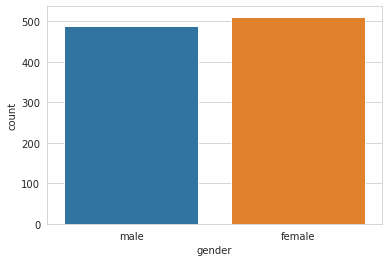

In [86]:
sns.countplot(x="gender", data=df_for_stats_with_age)

<AxesSubplot:xlabel='svc_rep', ylabel='count'>

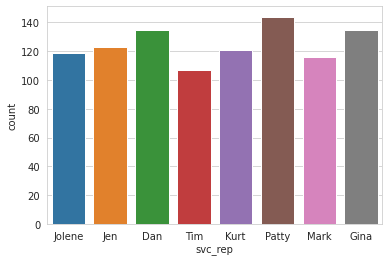

In [87]:
# Number of scores per svc rep 
sns.countplot(x="svc_rep", data=df_for_stats_without_age_bank_loc)

In [88]:
# Average score for each service rep
df_svc_repo_avg_score = df_for_stats_with_age.groupby("svc_rep").mean()
df_svc_repo_avg_score

,age,compound
svc_rep,,
Dan,50.348148,0.170894
Gina,52.051852,0.177058
Jen,50.211382,0.126311
Jolene,49.537815,0.184029
Kurt,50.619835,0.194394
Mark,49.275862,0.162597
Patty,47.548611,0.087267
Tim,52.504673,0.139663


In [89]:
# Average score for each service rep per bank_loc per gender
df_svc_repo_gender_avg_score = df_for_stats_with_age.groupby(["svc_rep", "gender"]).mean()
df_svc_repo_gender_avg_score

age  compound
svc_rep gender                     
Dan     female  50.750000  0.163886
        male    49.888889  0.178903
Gina    female  52.402985  0.144088
        male    51.705882  0.209543
Jen     female  49.809524  0.125654
        male    50.633333  0.127002
Jolene  female  48.476923  0.172637
        male    50.814815  0.197743
Kurt    female  49.000000  0.182809
        male    52.111111  0.205060
Mark    female  50.161290  0.156535
        male    48.259259  0.169557
Patty   female  45.424658  0.113264
        male    49.732394  0.060537
Tim     female  52.921569  0.130918
        male    52.125000  0.147627

In [90]:
# Average score for each service rep per bank_loc
df_svc_repo_bank_loc_avg_score = df_for_stats_with_age.groupby(["svc_rep", "bank_loc"]).mean()
df_svc_repo_bank_loc_avg_score

age  compound
svc_rep bank_loc                     
Dan     East      53.960000  0.224104
        North     49.250000  0.179461
        South     51.189189  0.191854
        West      48.333333  0.118769
Gina    East      50.562500  0.184934
        North     51.413793  0.166686
        South     52.305556  0.138411
        West      53.552632  0.214953
Jen     East      49.612903  0.185635
        North     50.185185  0.213241
        South     48.437500  0.070553
        West      52.515152  0.053527
Jolene  East      48.457143  0.251620
        North     50.833333  0.171033
        South     51.115385  0.287742
        West      48.529412  0.044315
Kurt    East      49.000000  0.403100
        North     51.678571  0.153207
        South     51.619048  0.085979
        West      49.354839  0.243832
Mark    East      48.071429  0.064918
        North     56.058824  0.062065
        South     48.228571  0.151471
        West      48.027778  0.296861
Patty   East      47.526316  0.087926
        North     45.750000  0.054488
        South     47.766667  0.188640
        West      49.388889  0.038514
Tim     East      50.925926  0.104022
        North     52.482759  0.204793
        South     54.571429  0.047824
        West      52.500000  0.173067

In [91]:
# min score for each service rep per gender
df_svc_repo_bank_loc_min_score = df_for_stats_without_age_bank_loc.groupby(["svc_rep", "gender"]).min()
df_svc_repo_bank_loc_min_score

compound
svc_rep gender          
Dan     female   -0.7351
        male     -0.7351
Gina    female   -0.9300
        male     -0.7693
Jen     female   -0.9300
        male     -0.7845
Jolene  female   -0.7351
        male     -0.7351
Kurt    female   -0.7351
        male     -0.7351
Mark    female   -0.7351
        male     -0.7351
Patty   female   -0.8807
        male     -0.9300
Tim     female   -0.8910
        male     -0.9300

In [92]:
# max score for each service rep per gender
df_svc_repo_bank_loc_max_score = df_for_stats_without_age_bank_loc.groupby(["svc_rep", "gender"]).max()
df_svc_repo_bank_loc_max_score

compound
svc_rep gender          
Dan     female    0.8658
        male      0.8658
Gina    female    0.8832
        male      0.8832
Jen     female    0.8832
        male      0.8658
Jolene  female    0.8658
        male      0.8832
Kurt    female    0.8807
        male      0.8658
Mark    female    0.9582
        male      0.7902
Patty   female    0.8658
        male      0.8658
Tim     female    0.8658
        male      0.8658

In [93]:
# Load data into neo4j
# Saving sample file for testing later on
df_total.to_json("df_total.json", orient="records", lines=True)

In [94]:
df_total.head()

,email,gender,nat,phone,first,last,title,age,date,city,...,longitude,description,offset,svc_rep,bank_loc,Quote,neg,neu,pos,compound
0,cody.jimenez@example.com,male,US,(016)-936-8291,Cody,Jimenez,Mr,62.0,1959-10-19T13:47:44.937Z,Dayton,...,-112.3224,"Adelaide, Darwin",+9:30,Jolene,East,"All diseases run into one, old age.",0.000,1.000,0.000,0.0000
1,barry.herrera@example.com,male,US,(057)-431-3465,Barry,Herrera,Mr,61.0,1960-04-21T03:53:58.197Z,Yakima,...,-126.9120,Mid-Atlantic,-2:00,Jen,West,"Alas, after a certain age every man is respons...",0.135,0.581,0.284,0.3182
2,brett.stevens@example.com,male,US,(914)-931-0572,Brett,Stevens,Mr,28.0,1993-12-24T18:58:43.001Z,North Valley,...,31.9468,"Tokyo, Seoul, Osaka, Sapporo, Yakutsk",+9:00,Jolene,South,"When grace is joined with wrinkles, it is ador...",0.000,0.607,0.393,0.8658
3,stella.parker@example.com,female,US,(936)-406-8825,Stella,Parker,Mrs,33.0,1988-06-16T14:34:05.110Z,Boise,...,-49.4416,"Bangkok, Hanoi, Jakarta",+7:00,Jen,East,Age is not a particularly interesting subject....,0.115,0.885,0.000,-0.3559
4,denise.gonzales@example.com,female,US,(823)-043-4812,Denise,Gonzales,Ms,36.0,1985-07-26T09:59:43.160Z,Salt Lake City,...,172.7736,"Adelaide, Darwin",+9:30,Jolene,North,My notion of a wife at 40 is that a man should...,0.000,0.902,0.098,0.3612


In [95]:
df_total_list = df_total.values.tolist()

In [96]:
# Taken from: https://neo4j.com/docs/api/python-driver/current/
def open_neo4j(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password), encrypted=False)
    return driver

def close_neo4j(driver):
    # Don't forget to close the driver connection when you are finished with it
    driver.close()

In [97]:
user = "neo4j"
password = "test"
scheme = "bolt" 
host_name = "0.0.0.0"
port = 7687
url = f"{scheme}://{host_name}:{port}"
# Got error: ServiceUnavailable: Failed to establish connection to IPv4Address(('0.0.0.0', 7687)) 
#(reason [Errno 111] Connection refused)
# OR 
# ServiceUnavailable: Unable to retrieve routing information

In [98]:
driver = open_neo4j(url,user,password)

ServiceUnavailable: Failed to establish connection to IPv4Address(('0.0.0.0', 7687)) (reason [Errno 111] Connection refused)

In [ ]:
def _create_and_return_interaction(tx, svc_rep, cus_name):

    # To learn more about the Cypher syntax,
    # see https://neo4j.com/docs/cypher-manual/current/

    # The Reference Card is also a good resource for keywords,
    # see https://neo4j.com/docs/cypher-refcard/current/

    query = (
        "CREATE (p1:Person { name: $svc_rep }) "
        "CREATE (p2:Person { name: $cus_name }) "
        "CREATE (p1)-[:TALKEDTO]->(p2) "
        "RETURN p1, p2"
    )
    result = tx.run(query, person1_name=svc_rep, person2_name=cus_name)
    try:
        return [{"p1": record["p1"]["name"], "p2": record["p2"]["name"]}
                for record in result]
    # Capture any errors along with the query and data for traceability
    except ServiceUnavailable as exception:
        logging.error("{query} raised an error: \n {exception}".format(
            query=query, exception=exception))
        raise

In [ ]:
# Create relationship between customer and rep
for i in df_total_list:
    driver.create_friendship(i[4], i[-7])

In [ ]:
close_neo4j(driver)

In [ ]:
print("Done!")